In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
subjects_to_be_ignored = [21269692]
subject_sex = 'female'
prototype_flag = True

deconfound_flag = True
# if deconfound_flag == True:
#     import matlab.engine
#     eng = matlab.engine.start_matlab()
    
IDP_cuttoff_nan = 1.0
# vars_cutoff_nan = 0.01
vars_cutoff_nan = 0.1

In [3]:
!ls ../

Analsysis Female New
Analysis - SFCN vs HGL
Analysis Male New
Analysis_data
MRI-based age prediction using hidden Markov models - ScienceDirect.html
additional_codes
data_examples
figures
logs
predictions


In [7]:
# Identify Correct File to Load

IDP_file = '../Analsysis Female New/female_test_IDPs.h5'
confounds_file = '../Analsysis Female New/female_test_conf12.h5'
data_file = 'female_test.pkl'

confounds = h5py.File(confounds_file, 'r')
confounds = confounds['conf12'][()]

IDP_h5 = h5py.File(IDP_file, 'r')
subjects_h5 = IDP_h5['subjects'][()]

# Load the relevant dataframe based on the required modality

df = pd.read_pickle(data_file)

IDP_h5 = h5py.File(IDP_file, 'r')
IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
vars_i_deconf = IDP_h5['vars_i_deconf'][()]
subjects_h5 = IDP_h5['subjects'][()]

# Useful Functions

# def deconfound_inputs(deltas):
    
#     confounds = h5py.File('ICA/male_test_conf12.h5', 'r')
#     confounds = confounds['conf12'][()]
    
#     deltas_deconfounds = eng.NetsUnconfoundWrapper(eng.transpose(matlab.double(deltas.tolist())), 
#                                   matlab.double(confounds.tolist()))
    
#     deltas_deconfounds = np.asarray(deltas_deconfounds).flatten()
    
#     return deltas_deconfounds

def deconfound_inputs(y):
    
    y = y - y.mean(axis=0)
    if np.sum(np.isnan(y)) == 0:
        beta = np.linalg.pinv(confounds).dot(y)
        beta[np.abs(beta) < 1e-10] = 0
        yd = y - confounds.dot(beta)
        yd = yd - yd.mean()
    else:
        print('ERROR! Encoundered a NaN! Function Needs Updating!')
    
    return yd

def apply_FDR_correction(p_values):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    Wrapper for Benjamini/Hochberg (non-negative) p-value correction for multiple tests.
    '''
    p_values_corrected = mt.multipletests(p_values, alpha=0.05, method='fdr_bh')[1] 
    
    return p_values_corrected


def standardize_data(variables):
    '''
    Code addapted from Emma Bluemke & Nicola Dinsdale
    '''

    number_of_subjects=variables.shape[0]

    # Compute the arithmetic mean & std along the specified axis, ignoring NaNs.
    variables_mean_ignore_NaNs = np.nanmean(variables,axis=0)
    variables_std_ignore_NaNs = np.nanstd(variables,axis=0)

    # We standardize the data
    variables_scaled = variables - np.tile(variables_mean_ignore_NaNs,(number_of_subjects,1))
    variables_scaled = variables_scaled / np.tile(variables_std_ignore_NaNs,(number_of_subjects,1))

    # Calculate how many variables are non NaN
    number_of_non_NaN =np.sum(np.isnan(variables)==False,axis=0) #np.nanstd has N**0.5 in divisor

    return variables_scaled, number_of_non_NaN


def correlate_with_fdr_correction(deltas, ukb_variables):
    """
    Code addapted from Emma Bluemke & Nicola Dinsdale

    correlate age deltas with rows in ukb_variables
    returns pearson_r, t_test_statistic, p_values_corrected, p_values of length number_of_variables

    pearson_r = raw Pearson correlation value (between -1 and 1)
    t_test_statistic t test statistic for each variable ()
    p_values_corrected is corrected p-values values (fdr corrected)
    p_values is non corrected p-values
    """

    ukb_variables_scaled , ukb_variales_number_of_non_NaN = standardize_data(ukb_variables)
    ukb_variables_NaN_matrix = np.isnan(ukb_variables_scaled)
    ukb_variables_scaled[ukb_variables_NaN_matrix] = 0

    sys.stdout.flush()

    number_of_variables = ukb_variables_scaled.shape[1]

    deltas_array = np.tile(deltas,(number_of_variables,1)).T
    deltas_array[ukb_variables_NaN_matrix] = np.nan
    deltas_array = standardize_data(deltas_array)[0]
    deltas_array[ukb_variables_NaN_matrix] = 0

    pearson_r = np.sum(deltas_array * ukb_variables_scaled, axis=0) / ukb_variales_number_of_non_NaN
    
    t_test_statistic = pearson_r * ((ukb_variales_number_of_non_NaN-2)/(1-pearson_r**2))**0.5
    t_test_statistic = np.abs(t_test_statistic)
    t_test_statistic[ukb_variales_number_of_non_NaN <= 2] = np.nan #set those that had d.o.f 0 to nan

    p_values=np.zeros(len(t_test_statistic))
    for j in range(len(t_test_statistic)):
        if t_test_statistic[j] is not np.nan:
            p_values[j] = student_t.sf(t_test_statistic[j], ukb_variales_number_of_non_NaN[j] - 2) * 2
        else:
            p_values[j]=np.nan

    p_values_NaN_matrix = np.isnan(p_values)
    p_values_no_NaN = p_values[p_values_NaN_matrix==False]
    p_values_corrected_raw = apply_FDR_correction(p_values_no_NaN)

    p_values_corrected=np.zeros(len(p_values))
    p_values_corrected[p_values_NaN_matrix==False] = p_values_corrected_raw
    p_values_corrected[p_values_NaN_matrix==True] = np.nan

    return pearson_r, t_test_statistic, p_values_corrected, p_values

def align_subjects(subjects_df, subjects_h5, age_delta_decon, subjects_to_be_ignored):
    '''
    Here we make sure that the subjects match between the results and the nIDP/IDP dataframes
    The subjects_df uses slightly older data, and subjects might have left the study since it's generation
    If need be, this will be corrected at a later stage!
    '''
    
    if len(subjects_df) == len(subjects_h5):
        assert (subjects_df == subjects_h5).all()
    else:
        idx_elim = np.where(subjects_df == subjects_to_be_ignored)[0][0]
        subjects_df = np.delete(subjects_df, idx_elim)
        assert (subjects_df == subjects_h5).all()
        age_delta_decon = np.delete(age_delta_decon, idx_elim)
    return subjects_df, age_delta_decon

def correlations_and_plots(age_delta_decon, deconf_subset, names_subset, idxs, categories_subset, title, 
                           corr_flag='IDP'):
    
    corr_results = correlate_with_fdr_correction(age_delta_decon, deconf_subset)
    
    corr_df = pd.DataFrame.from_dict({
        'idx': idxs,
        "names": names_subset,
        'Categories': categories_subset,
        "pearson_r": corr_results[0],
        "t_test_statistic": corr_results[1],
        "p_values_corrected": corr_results[2],
        "p_values": corr_results[3],
        "abs_pearson_r": np.abs(corr_results[0]),
        "log_p_values": -np.log10(corr_results[3]),
        "log_p_values_corrected": -np.log10(corr_results[2]),
    })
    
    if corr_flag == 'IDP':
        short_p_values = np.extract(corr_df.p_values !=0, corr_df.p_values)
        bonferroni_threshold = 0.05/len(short_p_values) #... Bonferroni
    else:
        bonferroni_threshold = 0.05/len(corr_df.p_values) #... Bonferroni
    bonferroni_threshold = -np.log10(bonferroni_threshold)

    arguments = np.argsort(corr_df.p_values_corrected)
    sorted_p_values_corrected = corr_df.p_values_corrected[arguments]
    sorted_p_values = corr_df.p_values[arguments]
    if len(sorted_p_values_corrected[sorted_p_values_corrected<=0.05]):
#         arguments_no_NaN = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])        
#         false_discovery_rate = sorted_p_values[arguments_no_NaN]

        false_discovery_rate = np.nanmax(sorted_p_values[sorted_p_values_corrected<=0.05])
        false_discovery_rate = -np.log10(false_discovery_rate)
        FDR_flag = True
    else:
        FDR_flag = False
        false_discovery_rate = None

    if corr_flag == 'IDP':
        x_text_location = -120
        bonferroni_threshold_text = 1
        false_discovery_rate_text = -2
        colorCycle = 'Paired'
    else:
        x_text_location = -750
        bonferroni_threshold_text = 0.1
        false_discovery_rate_text = -0.5
        colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
#         colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']


    
    
    plt.figure(figsize=(16, 9.6))
    
    if corr_flag == 'IDP':
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )
    else:
        sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                    y='log_p_values', hue='Categories', 
                        palette=colorCycle
                       )  
    
    plt.ylabel('-log(P)')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.axhline(y = bonferroni_threshold, linestyle='--', color='r')
    plt.text(x=x_text_location, y=bonferroni_threshold + bonferroni_threshold_text, s='Bonf.')
    if false_discovery_rate is not None:
        plt.axhline(y = false_discovery_rate, linestyle='--', color='r')
        plt.text(x=x_text_location, y=false_discovery_rate + false_discovery_rate_text, s='FDR')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.show()
    
    return corr_df, bonferroni_threshold, false_discovery_rate



# IDP_names = np.loadtxt("../Analsysis Female New/IDP_names.txt", dtype=str, delimiter='\n')
with open('../Analsysis Female New/IDP_names.txt') as f:
    IDP_names = f.readlines()
    IDP_names = [l.strip('\n\r') for l in IDP_names]
    IDP_names = np.array(IDP_names)
# IDP_categories = np.loadtxt("../Analsysis Female New/IDP_categories.txt", dtype=str, delimiter='\n')
with open('../Analsysis Female New/IDP_categories.txt') as f:
    IDP_categories = f.readlines()
    IDP_categories = [l.strip('\n\r') for l in IDP_categories]
    IDP_categories = np.array(IDP_categories)
with open('../Analsysis Female New/varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
# vars_categories = np.loadtxt("../Analsysis Female New/vars_categories.txt", dtype=str, delimiter='\n')
with open('../Analsysis Female New/vars_categories.txt') as f:
    vars_categories = f.readlines()
    vars_categories = [l.strip('\n\r') for l in vars_categories]
    vars_categories = np.array(vars_categories)

IDPIDX = np.arange(0, len(IDP_names), 1).astype(int)
varsIDX = np.arange(0, len(varsHeader), 1).astype(int)

# # Identify Correct File to Load

# data_file = 'male'
# IDP_file = 'male'
# if subject_sex == 'female':
#     data_file = 'fe' + data_file
#     IDP_file = 'fe' + IDP_file
# if prototype_flag == True:
#     data_file += '_prototype'
# data_file += '.pkl'
# IDP_file += '_test_IDPs.h5'

# # Load the relevant dataframe based on the required modality

# df = pd.read_pickle(data_file)

# IDP_h5 = h5py.File(IDP_file, 'r')
# IDPs_i_deconf = IDP_h5['IDPs1_i_deconf'][()]
# vars_i_deconf = IDP_h5['vars_i_deconf'][()]
# subjects_h5 = IDP_h5['subjects'][()]

# Filter out those IDPs and Vars which have too many NaNs (see 7.1 for more details!)

IDP_perc_not_nan = np.sum(np.isnan(IDPs_i_deconf)==False,axis=0) / IDPs_i_deconf.shape[0]
vars_perc_not_nan = np.sum(np.isnan(vars_i_deconf)==False,axis=0) / vars_i_deconf.shape[0]
IDP_idx_nan_cutoff = np.where(IDP_perc_not_nan >= IDP_cuttoff_nan)[0]
vars_idx_nan_cutoff = np.where(vars_perc_not_nan >= vars_cutoff_nan)[0]

IDP_names_subset = IDP_names[IDP_idx_nan_cutoff]
IDPs_i_deconf_subset = IDPs_i_deconf[:, IDP_idx_nan_cutoff]
IDP_categories_subset = IDP_categories[IDP_idx_nan_cutoff]
varsHeader_subset = varsHeader[vars_idx_nan_cutoff]
vars_i_deconf_subset = vars_i_deconf[:, vars_idx_nan_cutoff]
vars_categories_subset = vars_categories[vars_idx_nan_cutoff]
IDPIDX_subset = IDPIDX[IDP_idx_nan_cutoff]
varsIDX_subset = varsIDX[vars_idx_nan_cutoff]

del IDP_h5


In [8]:
df.head()

,modality,dataframe
0,T1L_large_HGL,Unnamed: 0 target_age mean_output_age ...
1,T1L_large_SFCN,Unnamed: 0 target_age mean_output_age ...
2,T1L_large_SFCN_50b,Unnamed: 0 target_age mean_output_age ...
3,T1L_large_SFCN_50b10s,Unnamed: 0 target_age mean_output_age ...
4,T1L_HGL,Unnamed: 0 target_age mean_output_age ...


In [9]:
df.iloc[0].dataframe.head()

,Unnamed: 0,target_age,mean_output_age,mean_age_delta,loss,output_age_decon,output_age_decon3,age_delta_decon,age_delta_decon3
0,24806531,67.670662,65.482110,2.188553,4.789764,65.866897,65.716459,-1.803765,-1.954203
1,24237795,77.280936,73.253136,4.027800,16.223176,75.487581,75.837645,-1.793355,-1.443291
2,24748274,58.301941,55.103355,3.198585,10.230947,53.017792,53.090029,-5.284149,-5.211912
3,25463415,58.056694,61.257590,-3.200897,10.245743,60.636857,60.806181,2.580163,2.749487
4,25313661,59.653082,55.859596,3.793486,14.390536,53.954033,54.192336,-5.699049,-5.460746


In [10]:
np.unique(IDP_categories_subset)

array(['Regional and Tissue Volume', 'WM Tract Diffusivity',
       'WM Tract FA', 'WM Tract ICVF', 'WM Tract ISOVF', 'WM Tract MO',
       'WM Tract OD', 'White Matter Hyperintensity Colume',
       'rfMRI Connectivity', 'rfMRI Node Amplitude', 'tfMRI Activation'],
      dtype='<U34')

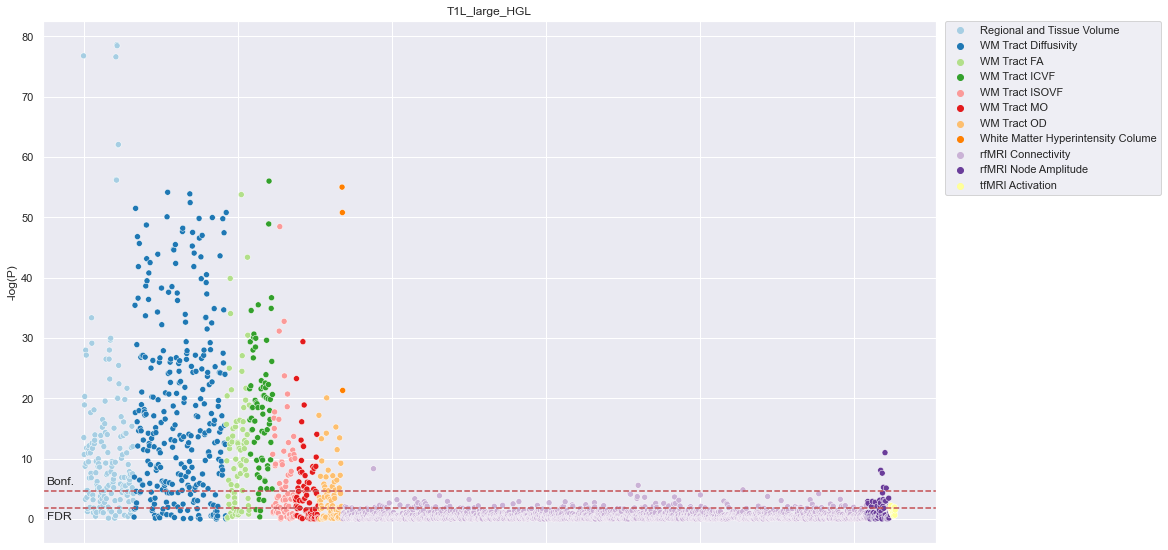

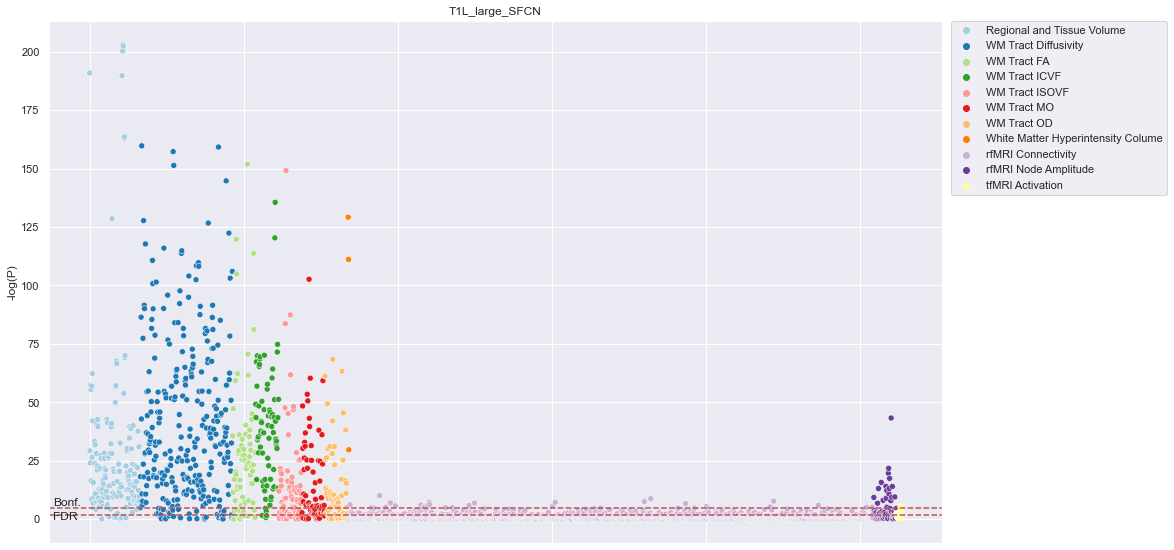

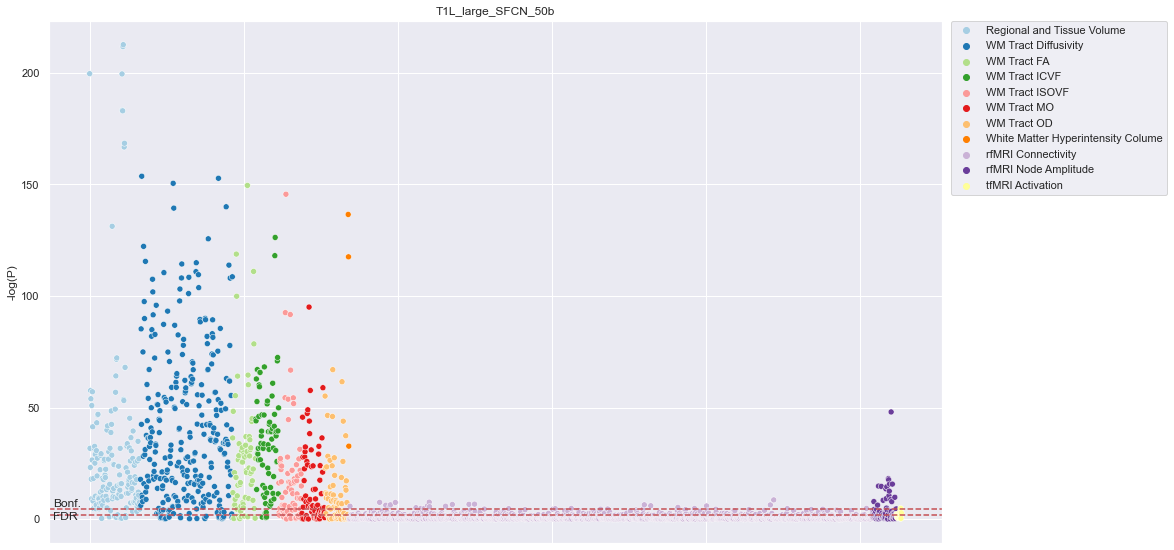

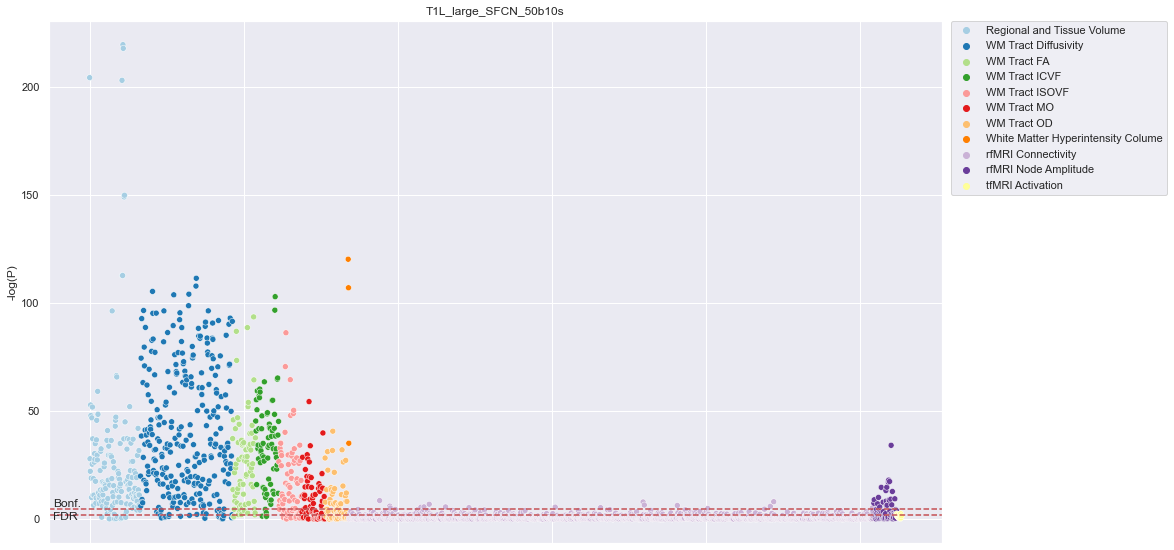

In [11]:
IDP_corrs = []
IDP_mods = []
IDP_bnf_thrs = []
IDP_fdr_thrs = []

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    modality = df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
    
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = IDPs_i_deconf_subset, 
                                    names_subset = IDP_names_subset, idxs = IDPIDX_subset,
                                    categories_subset = IDP_categories_subset,
                                    title = modality, corr_flag='IDP')
    IDP_mods.append(modality)
    IDP_corrs.append(corr_df)
    IDP_bnf_thrs.append(bonferroni_threshold)
    IDP_fdr_thrs.append(false_discovery_rate)
    
    if idx==3:
        break
    
IDP_df = pd.DataFrame.from_dict({
    'modality': IDP_mods,
    'bonf': IDP_bnf_thrs,
    'fdr': IDP_fdr_thrs,
    'dataframe': IDP_corrs
})

In [12]:
IDP_df.to_pickle('female_IDP.pkl', protocol = 4)

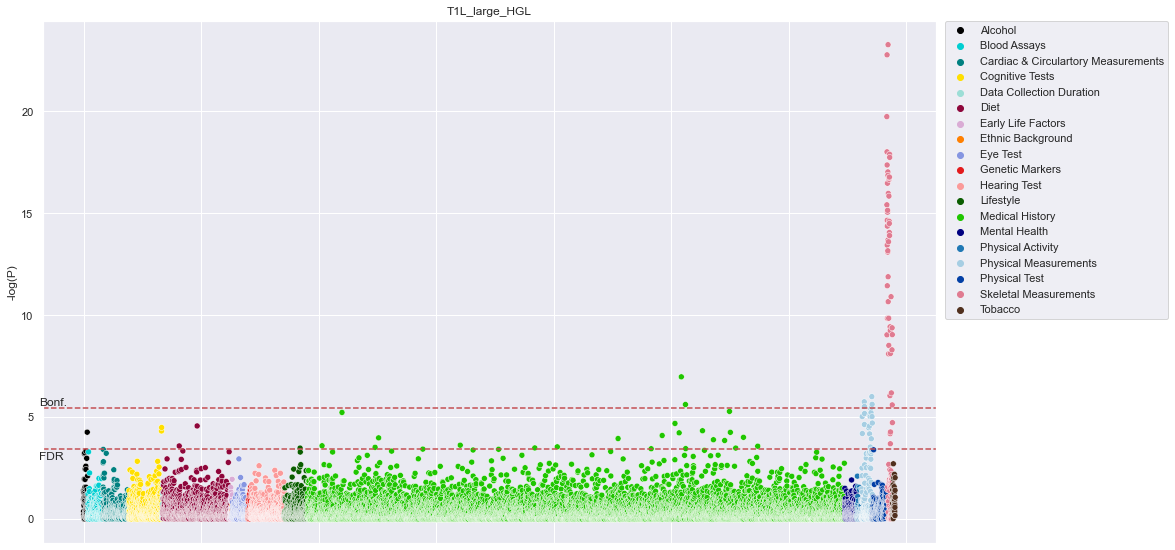

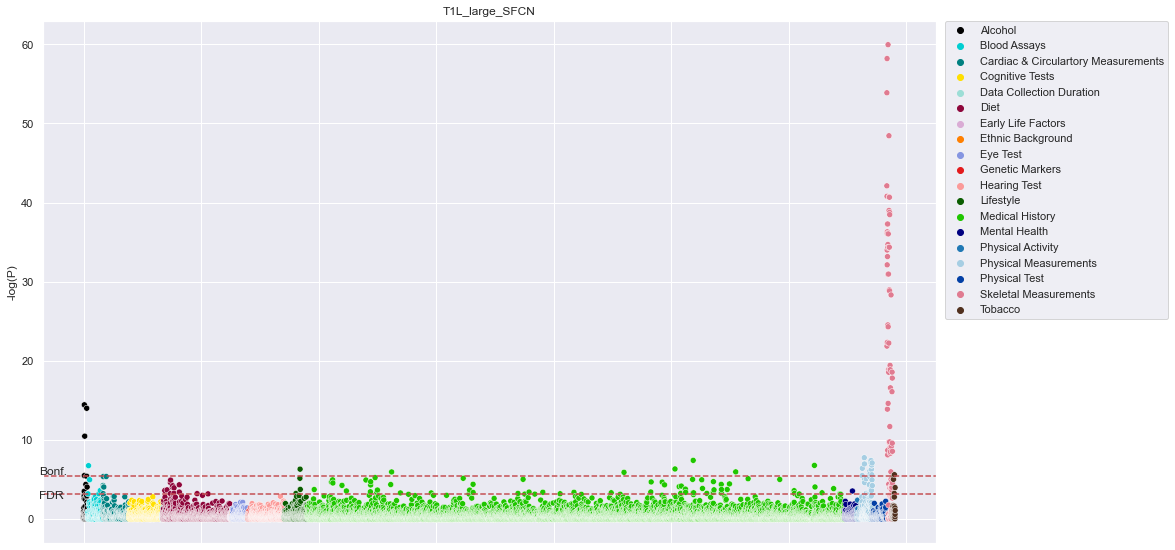

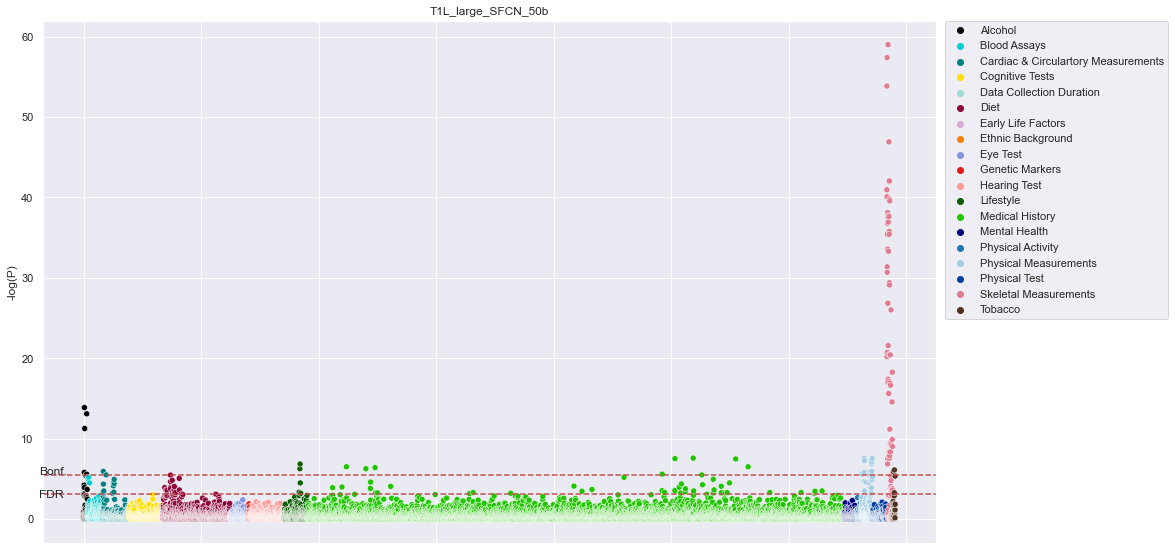

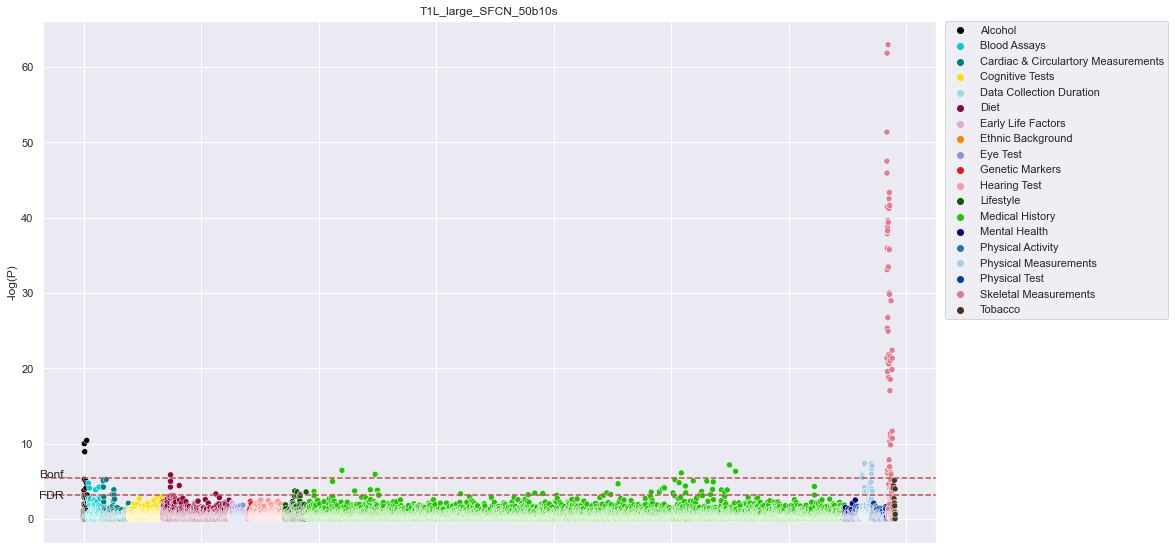

In [13]:
vars_corrs = []
vars_mods = []
vars_bnf_thrs = []
vars_fdr_thrs = []

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    modality = df.iloc[idx].modality
    age_delta_decon = df_mod.age_delta_decon.to_numpy()
    subjects = df_mod['Unnamed: 0'].to_numpy()
    subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
                                                  age_delta_decon, subjects_to_be_ignored)
    
    if deconfound_flag == True:
        age_delta_decon = deconfound_inputs(age_delta_decon)
        
        
    corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
                                    age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
                                    names_subset = varsHeader_subset, idxs = varsIDX_subset,
                                    categories_subset = vars_categories_subset,
                                    title = modality, corr_flag='vars')
    vars_mods.append(modality)
    vars_corrs.append(corr_df)
    vars_bnf_thrs.append(bonferroni_threshold)
    vars_fdr_thrs.append(false_discovery_rate)
    
    if idx==3:
        break
    
vars_df = pd.DataFrame.from_dict({
    'modality': vars_mods,
    'bonf': vars_bnf_thrs,
    'fdr': vars_fdr_thrs,
    'dataframe': vars_corrs
})

In [14]:
# vars_corrs = []
# vars_mods = []
# vars_bnf_thrs = []
# vars_fdr_thrs = []

# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     modality = df.iloc[idx].modality
#     age_delta_decon = df_mod.age_delta_decon.to_numpy()
#     subjects = df_mod['Unnamed: 0'].to_numpy()
#     subjects, age_delta_decon = align_subjects(subjects, subjects_h5, 
#                                                   age_delta_decon, subjects_to_be_ignored)
    
#     if deconfound_flag == True:
#         age_delta_decon = deconfound_inputs(age_delta_decon)
        
        
#     corr_df, bonferroni_threshold, false_discovery_rate = correlations_and_plots(
#                                     age_delta_decon = age_delta_decon, deconf_subset = vars_i_deconf_subset, 
#                                     names_subset = varsHeader_subset, 
#                                     categories_subset = vars_categories_subset,
#                                     title = modality, corr_flag='vars')
#     vars_mods.append(modality)
#     vars_corrs.append(corr_df)
#     vars_bnf_thrs.append(bonferroni_threshold)
#     vars_fdr_thrs.append(false_discovery_rate)
    
# vars_df = pd.DataFrame.from_dict({
#     'modality': vars_mods,
#     'bonf': vars_bnf_thrs,
#     'fdr': vars_fdr_thrs,
#     'dataframe': vars_corrs
# })

In [ ]:
vars_df.to_pickle('female_vars.pkl', protocol = 4)

In [ ]:
# if deconfound_flag == True:
#     eng.quit()

In [ ]:
# idp_df2 = IDP_df.iloc[np.where(IDP_df.modality=='swi')[0][0]].dataframe
# idp_df2[idp_df2.log_p_values>=idp_df2.bonferroni_threshold[0]].sort_values('log_p_values', ascending=False)

In [ ]:
vars_df.iloc[0].dataframe

Plot the effect sizes (like R^2) for each significant hit. Have one plot in one view of associations. How much of the variace are we explaining the in the phenotype. 2 time point for longitudinal effects. 

In [30]:


def correlations_and_plots_subplot(ax, corr_df, bonferroni_threshold, false_discovery_rate, title):


    colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
    x_text_location = -750
    bonferroni_threshold_text = 0.1
    false_discovery_rate_text = -0.5

#     plt.figure(figsize=(16, 9.6))
    sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                y='log_p_values', hue='Categories', palette=colorCycle)  

    ax.set_ylabel('-log(P)')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.axhline(y = bonferroni_threshold, linestyle='--', color='r')
    ax.text(x=x_text_location, y=bonferroni_threshold + bonferroni_threshold_text, s='Bonf.')
    if false_discovery_rate is not None:
        ax.axhline(y = false_discovery_rate, linestyle='--', color='r')
        ax.text(x=x_text_location, y=false_discovery_rate + false_discovery_rate_text, s='FDR')
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax.set_title(title)


In [31]:
# df = pd.read_pickle('female_vars.pkl')

# titles = [
#     'HGL',
#     'SFCN',
#     'SFCN (50 bins)',
#     'SFCN (50 bins, 10 std)',
# ]

# ncols=1
# nrows=4
# # sz=7.2
# title_font_size=22
# ticks_font_size=18
# legend_font = 18

# # fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))
# fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(11.69,8.27))
# axes = axes.ravel()
# i = 0


# for idx in range(len(df)):
#     corr_df = df.iloc[idx].dataframe
#     bonferroni_threshold = df.iloc[idx].bonf
#     false_discovery_rate = df.iloc[idx].fdr
#     title = df.iloc[idx].modality
    
#     correlations_and_plots_subplot(ax=axes[idx], corr_df=corr_df, 
#                                    bonferroni_threshold=bonferroni_threshold, 
#                                    false_discovery_rate=false_discovery_rate,
#                                    title=titles[idx]
#                                   )
    
#     if idx==3:
#         break

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: Image size of 490123x1563 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 841.68x595.44 with 4 Axes>

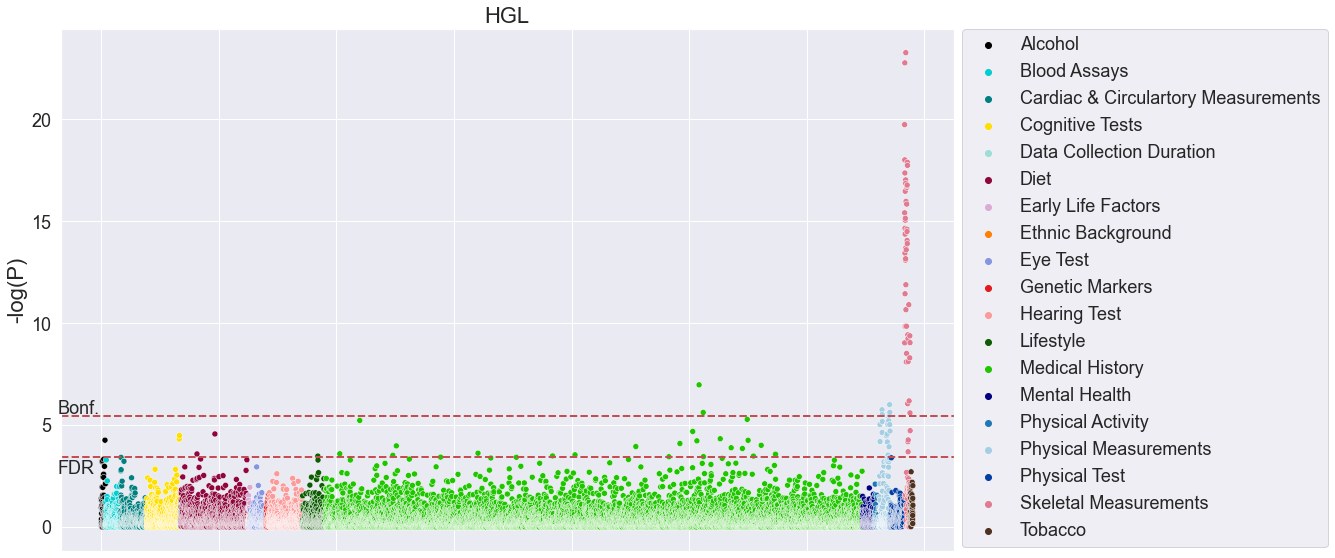

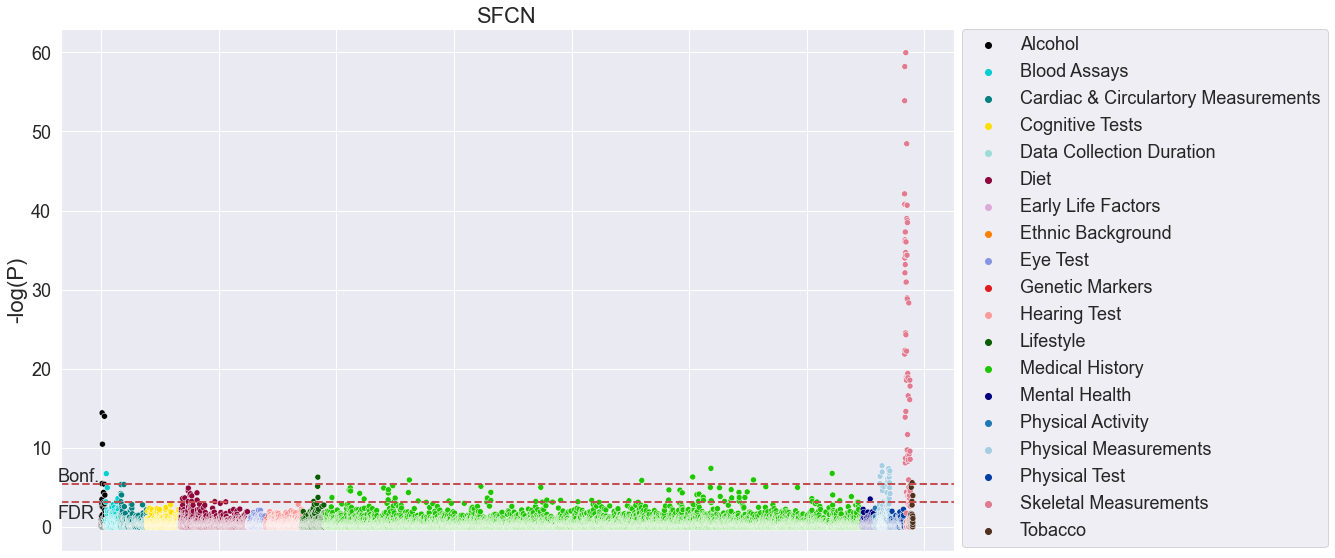

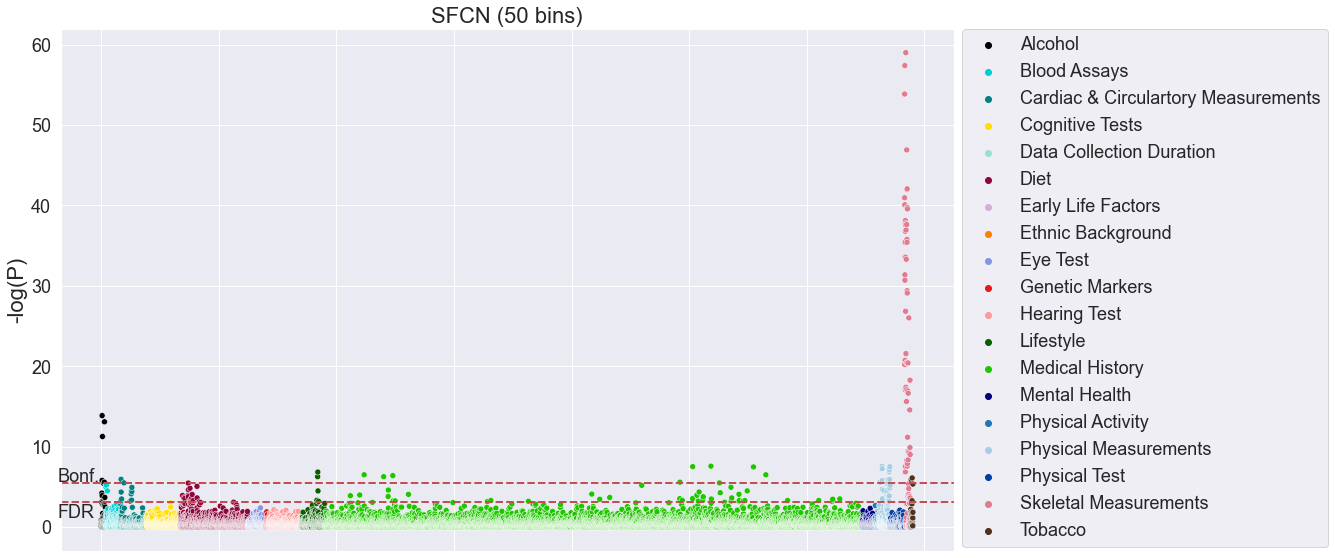

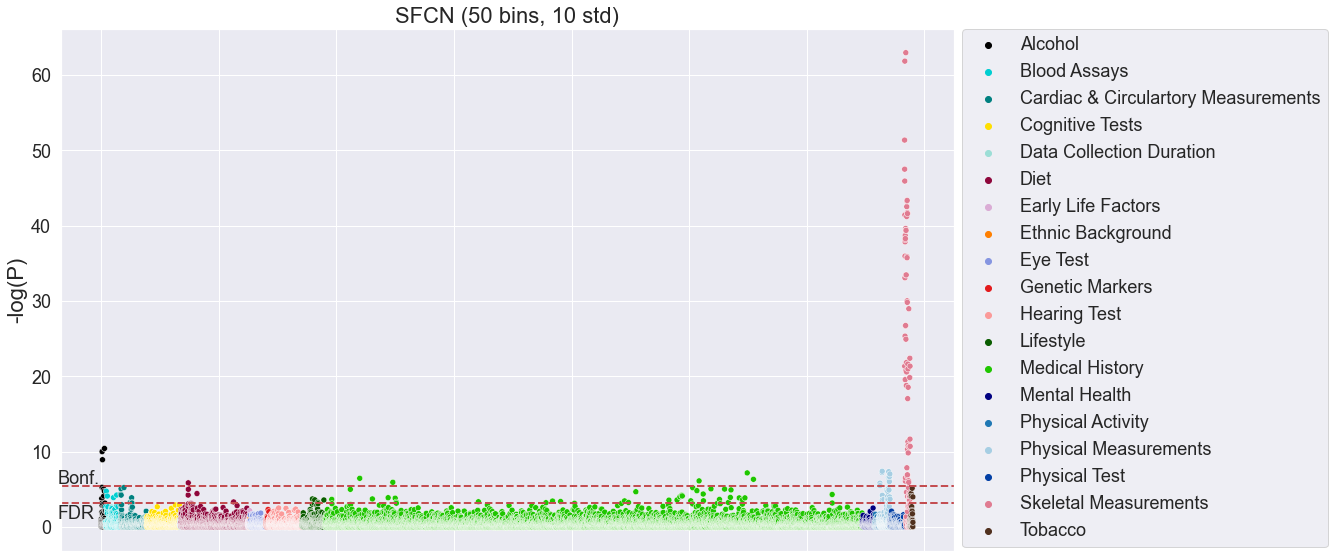

In [56]:
def correlations_and_plots_replot(corr_df, bonferroni_threshold, false_discovery_rate, title,
                                 figsize,
                                  ticks_font_size,
                                  title_font_size,
                                  legend_font,
                                  save_title,
                                 ):


    colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6','#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c','#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4','#a6cee3', '#023fa5', '#e07b91', '#50301e']
    x_text_location = -750
    bonferroni_threshold_text = 0.00429570699569 * corr_df.log_p_values.values.max()
    false_discovery_rate_text = - 0.03436565596552 * corr_df.log_p_values.values.max()


    fig = plt.figure(figsize=figsize)
    sns.scatterplot(data=corr_df.sort_values('Categories'), x=np.arange(0,len(corr_df)), 
                y='log_p_values', hue='Categories', palette=colorCycle)  

    plt.ylabel('-log(P)', fontsize=title_font_size)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.axhline(y = bonferroni_threshold, linestyle='--', color='r',  linewidth = 2)
    plt.text(x=x_text_location, y=bonferroni_threshold + bonferroni_threshold_text, s='Bonf.', fontsize=legend_font)
    if false_discovery_rate is not None:
        plt.axhline(y = false_discovery_rate, linestyle='--', color='r',  linewidth = 2)
        plt.text(x=x_text_location, y=false_discovery_rate + false_discovery_rate_text, s='FDR', fontsize=legend_font)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=legend_font)
    plt.title(title, fontsize=title_font_size)
    plt.xticks(fontsize= ticks_font_size)
    plt.yticks(fontsize= ticks_font_size)
    
    fig.savefig(save_title, bbox_inches='tight')

df = pd.read_pickle('female_vars.pkl')

titles = [
    'HGL',
    'SFCN',
    'SFCN (50 bins)',
    'SFCN (50 bins, 10 std)',
]

save_title = 'Manhattan_Plots'

# ncols=1
# nrows=4
# sz=7.2
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

# fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))
# fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(11.69,8.27))
axes = axes.ravel()
i = 0


for idx in range(len(df)):
    corr_df = df.iloc[idx].dataframe
    bonferroni_threshold = df.iloc[idx].bonf
    false_discovery_rate = df.iloc[idx].fdr
    title = df.iloc[idx].modality
    
    tmp_save_title = save_title + '_' + titles[idx] + '.png'
    
    correlations_and_plots_replot(corr_df=corr_df, 
                                   bonferroni_threshold=bonferroni_threshold, 
                                   false_discovery_rate=false_discovery_rate,
                                   title=titles[idx],
                                  figsize=figsize,
                                  ticks_font_size = ticks_font_size,
                                  title_font_size = title_font_size,
                                  legend_font = legend_font,
                                  save_title = tmp_save_title
                                  )
    
    if idx==3:
        break

In [46]:
corr_df.log_p_values.values.max()

62.97178727938845